In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

# Configuration for prettier plots
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

# 1. Load Data
# Note: The dataset uses a tab separator
df = pd.read_csv('marketing_campaign.csv', sep='\t')

print(f"Initial Shape: {df.shape}")
df.head(3)

Initial Shape: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0


# Phase 1: Advanced EDA & Data Engineering

Business Logic & Feature Engineering

In [12]:
def engineer_features(data):
    df_eng = data.copy()

    # 1. Age Extraction (Assuming current year is 2014 as per dataset context, or use current year)
    # The dataset is old, so using 2014 keeps the ages realistic relative to the data collection time.
    df_eng['Age'] = 2014 - df_eng['Year_Birth']

    # 2. Total Spend (The "Monetary" in RFM)
    # Summing up all specific spending columns
    spending_cols = [col for col in df_eng.columns if 'Mnt' in col]
    df_eng['Total_Spend'] = df_eng[spending_cols].sum(axis=1)

    # 3. Family Size (Total people in home)
    # Kidhome + Teenhome + Parents (assumed 1 if Single, 2 if Married/Partner)
    # Mapping Marital Status is tricky, let's simplify for the "Living_With" count
    df_eng['Marital_Status'] = df_eng['Marital_Status'].replace({
        'Married': 'Partner', 'Together': 'Partner',
        'Absurd': 'Single', 'Widow': 'Single',
        'YOLO': 'Single', 'Divorced': 'Single', 'Alone': 'Single'
    })
    df_eng['Is_Partner'] = df_eng['Marital_Status'].map({'Partner': 1, 'Single': 0})
    df_eng['Family_Size'] = df_eng['Kidhome'] + df_eng['Teenhome'] + df_eng['Is_Partner'] + 1

    # 4. Feature Selection: Drop redundant columns to keep it clean
    cols_to_drop = ['Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID', 'Dt_Customer']
    # Note: In a real pipeline, keep ID until the very end for tracking, but drop for EDA/Model
    df_eng = df_eng.drop(columns=cols_to_drop, errors='ignore')

    return df_eng

df_engineered = engineer_features(df)

Data Cleaning

In [13]:
def clean_data(data):
    df_clean = data.copy()

    # 1. Handling Missing Values
    # Income often has nulls. We fill with Median (robust to outliers)
    df_clean['Income'] = df_clean['Income'].fillna(df_clean['Income'].median())

    # 2. Outlier Removal (The "Sanity Check")
    # There are records with Age > 100 and Income > 600,000 (likely data entry errors)
    df_clean = df_clean[df_clean['Age'] < 90]
    df_clean = df_clean[df_clean['Income'] < 200000]

    print(f"Shape after cleaning: {df_clean.shape}")
    return df_clean

df_final = clean_data(df_engineered)

Shape after cleaning: (2236, 28)


Correlation Matrix

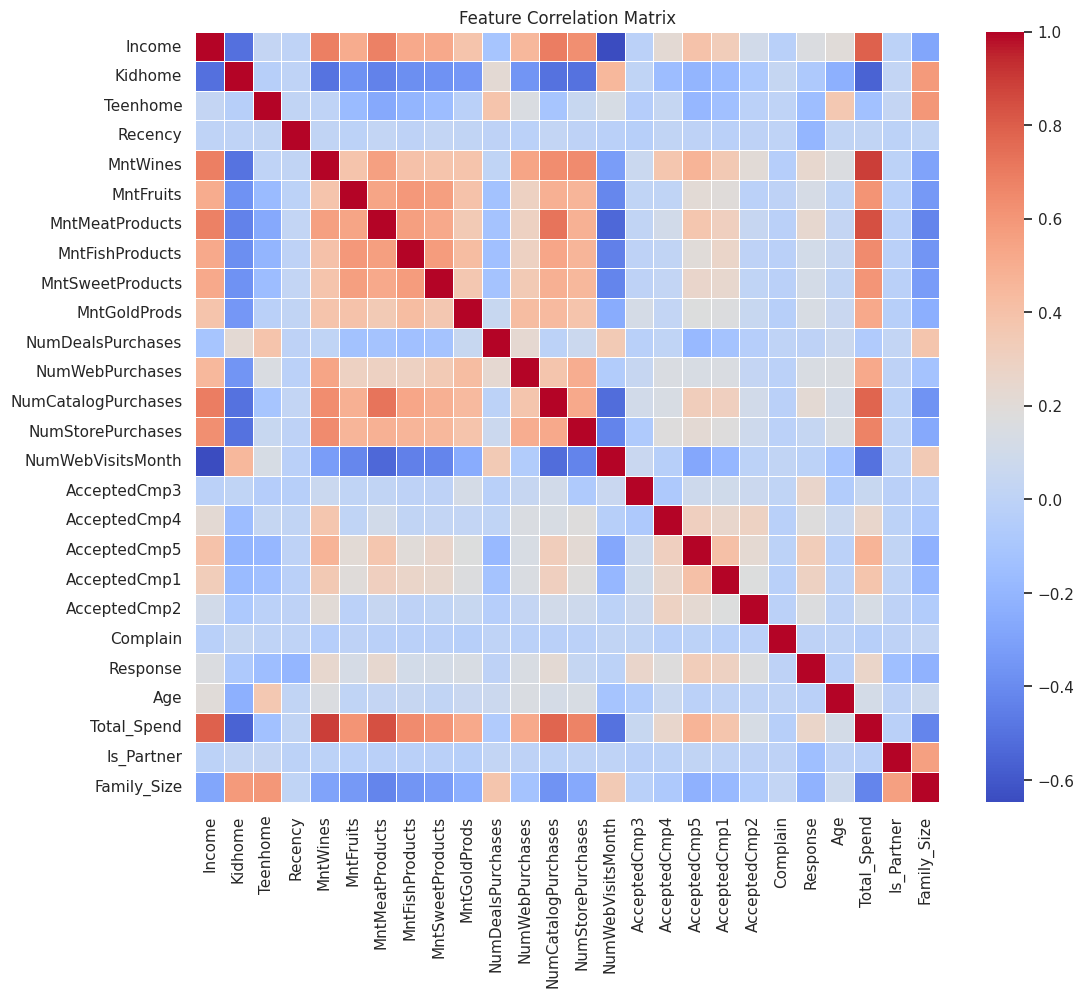

In [14]:
# Finding the "Drivers"
# We want to see what correlates with Total_Spend and Response
corr_matrix = df_final.select_dtypes(include=np.number).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

The "Elbow" Hint

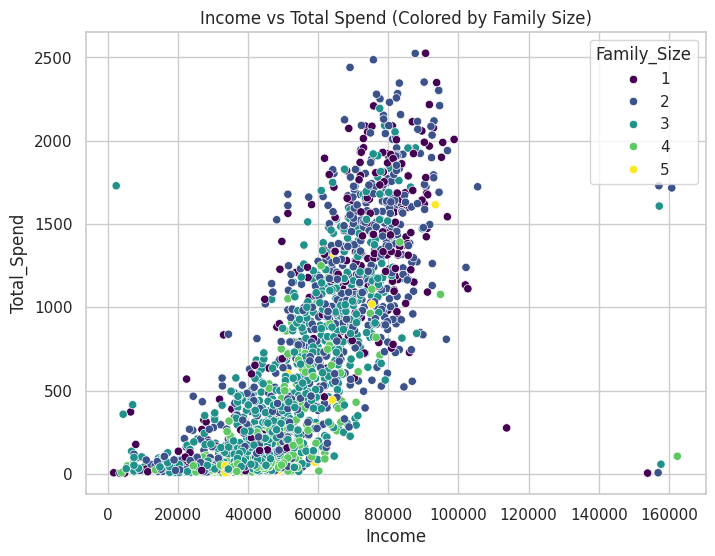

In [15]:
# Pairplot of Income vs Spend
# This visualization often hints at where the clusters might form naturally
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_final, x='Income', y='Total_Spend', hue='Family_Size', palette='viridis')
plt.title('Income vs Total Spend (Colored by Family Size)')
plt.show()

# Phase 2: Unsupervised Clustering & Profiling

Optimal Clusters

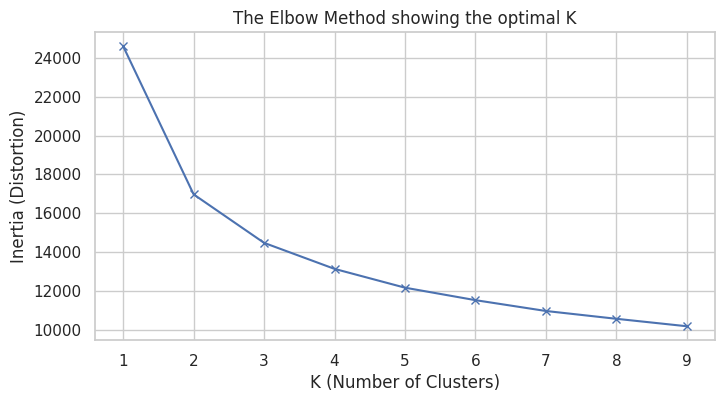

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Select features for clustering
# We exclude 'Response' (Target) and 'ID' because we want segments based on BEHAVIOR, not results.
cluster_cols = [
    'Income', 'Kidhome', 'Teenhome', 'Recency', 'Age',
    'Total_Spend', 'NumDealsPurchases', 'NumWebPurchases',
    'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'
]

# 2. Scaling (CRITICAL: K-Means is distance-based; Income (80,000) would dominate Age (50) without scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final[cluster_cols])

# 3. The Elbow Method to find 'K'
inertia = []
range_val = range(1, 10)

for i in range_val:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range_val, inertia, 'bx-')
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Inertia (Distortion)')
plt.title('The Elbow Method showing the optimal K')
plt.show()

Fitting the Model & Visualization (PCA)

Choosing K=4 instead of K=2 even when it is a very strong candidate


Why?

Business Nuance: A 2-cluster model usually just splits customers into "High Spenders" and "Low Spenders." That is too simple for a marketing team.

The "Middle" Class: Looking at above scatterplot, there is a massive density of people in the middle (Income 40k–70k). If you use K=2, these people get forced into either "Rich" or "Poor," losing their unique identity.

The Elbow Curve: Notice that the curve still drops significantly between 2 and 3, and settles around 4.

So let's proceed with K=4. This will likely give you distinct groups like "Elite," "Budget," "New Customers," and "Loyal Middle-Class.

# Phase 3: The Hybrid Prediction (Supervised Learning)

In [17]:
df_final.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age', 'Total_Spend', 'Is_Partner',
       'Family_Size'],
      dtype='object')

In [18]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Prepare X (Features) and y (Target)
# We drop 'Response' (Target) and 'ID' (Identifier)
# We KEEP 'Cluster' - this is our new "Hybrid" feature!
X = df_final.drop(['Response'], axis=1)
y = df_final['Response']

# 2. One-Hot Encoding for Categorical Variables
# XGBoost can handle categories, but standard OHE is safer for general compatibility
X = pd.get_dummies(X, drop_first=True)

# 3. Train/Test Split (Stratified is crucial for imbalanced data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Features Shape: {X_train.shape}")
print(f"Class Balance in Train:\n{y_train.value_counts(normalize=True)}")

Training Features Shape: (1788, 30)
Class Balance in Train:
Response
0    0.850671
1    0.149329
Name: proportion, dtype: float64


Training the XGBoost Model

scale_pos_weight to handle the imbalance (since "1s" are rare)

In [19]:
# 4. Initialize and Train XGBoost
# scale_pos_weight estimate: Total Negatives / Total Positives
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    scale_pos_weight=ratio,  # Handles class imbalance automatically
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:38:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluation & Business Metrics

Accuracy is misleading here. We look at Recall (did we catch the buyers?) and AUC

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       381
           1       0.54      0.72      0.62        67

    accuracy                           0.87       448
   macro avg       0.74      0.80      0.77       448
weighted avg       0.89      0.87      0.87       448

ROC-AUC Score: 0.9004


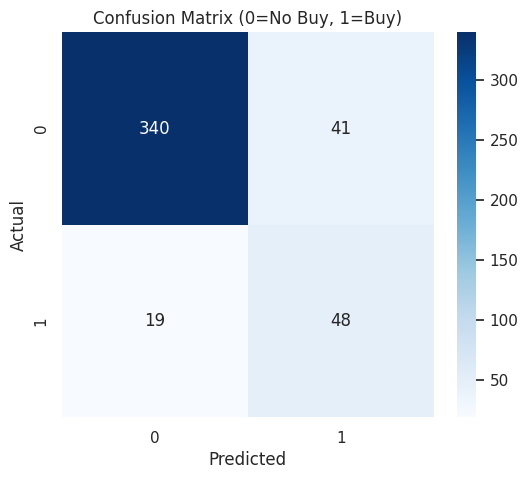

In [20]:
# 5. Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 6. Evaluation
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 7. Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (0=No Buy, 1=Buy)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Feature Importance

<Figure size 1000x800 with 0 Axes>

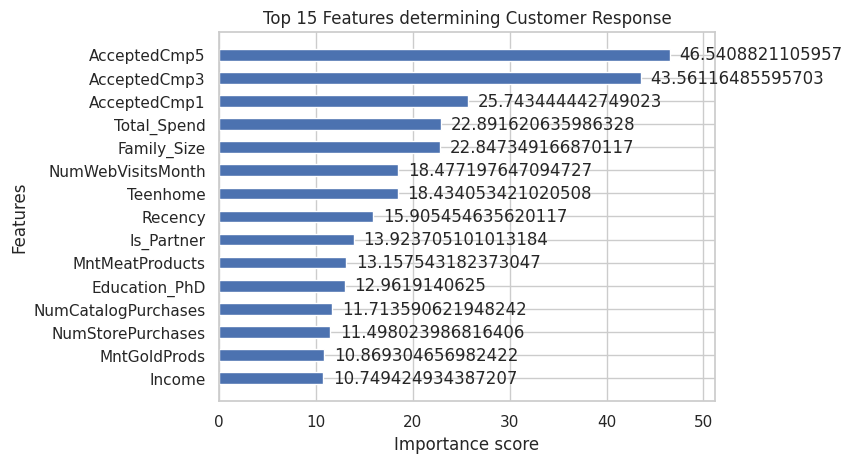

In [23]:
# 8. Feature Importance Plot
import xgboost as xgb

plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=15, importance_type='gain', height=0.5)
plt.title('Top 15 Features determining Customer Response')
plt.show()